ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

374

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [202]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.inspection import permutation_importance
from catboost import (CatBoostClassifier,
                        Pool,
                        EShapCalcType,
                        EFeaturesSelectionAlgorithm)

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
import optuna
from scipy.stats import mode

In [203]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [204]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [205]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [206]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [207]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [208]:
df_train.shape

(35172, 3)

In [209]:
df_test.shape

(6620, 3)

In [210]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [211]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [212]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [213]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [214]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [215]:
# активность сотрудников в train
count_user_id = df_train.user_id.value_counts(ascending=True).to_frame()

In [216]:
count_user_id

,count
user_id,
4,1
51,2
44,4
21,5
52,5
30,10
5,10
38,13
10,17


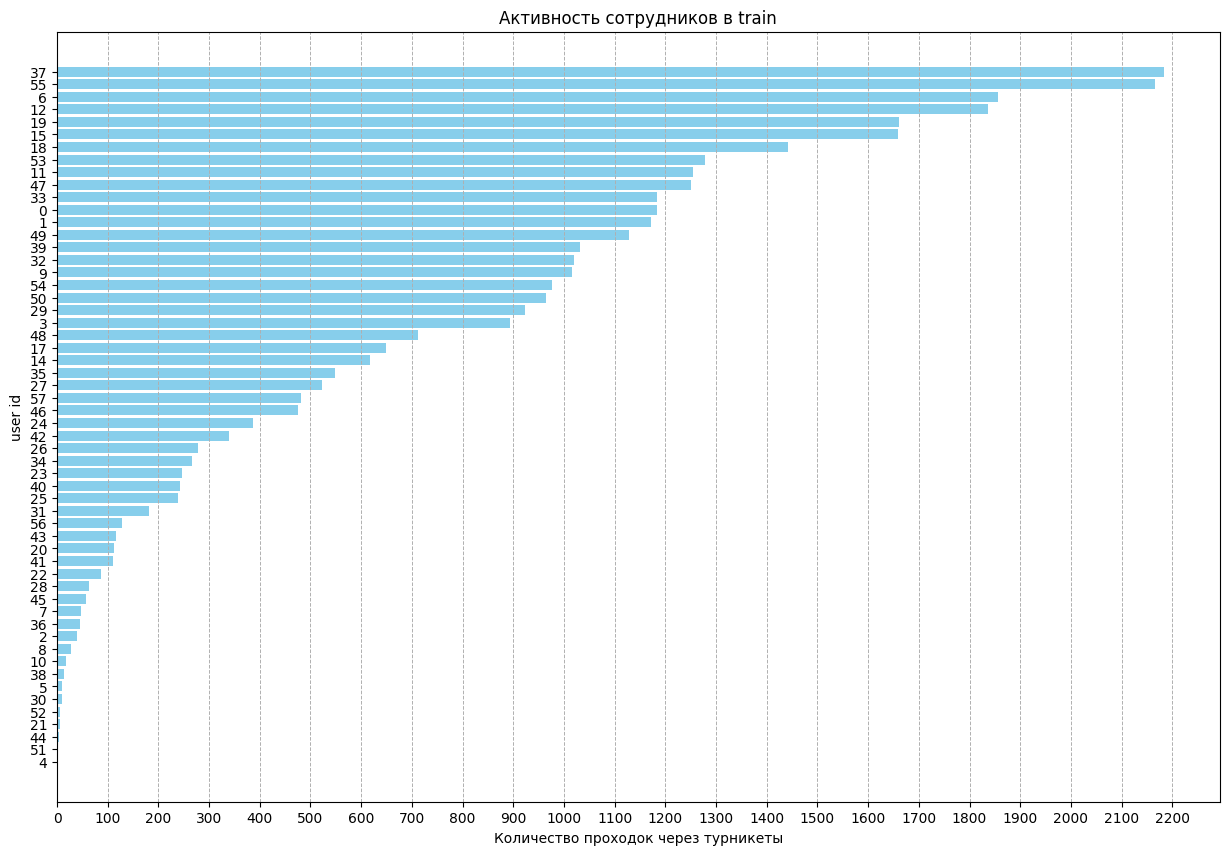

In [217]:
plt.figure(figsize=(15, 10))
plt.barh(count_user_id.index.astype(str), count_user_id['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user id')
plt.title('Активность сотрудников в train')
plt.xticks(np.arange(0, 2210, 100))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Удалим неактивных сотрудников, количество проходов через турникеты которых менее 100. Поскольку это слишком маленькие категории для обучения (подбор гиперпараметров модели будет выполняться с помощью кроссвалидации), и, скорее всего, этих сотрудников нет в test.

In [ ]:
len([0, 1, 2, 3, 6, 9, 11, 12, 14, 15, 17, 19, 23, 24, 25, 26, 29, 32, 33, 35, 37, 39, 43, 46, 49, 50, 54, 55, 56])

In [218]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 22, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]

In [219]:
27
18
31
48
8
47
36

36

In [ ]:
# 8 и 41

In [220]:
delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 27, 28, 31, 30, 34, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]
len(delete_user_id)

25

In [221]:
len(df_train.user_id.unique()) - len(delete_user_id)

31

In [222]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(27970, 3)

In [223]:
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

Количество сотрудников в train: 31


In [224]:
df_train.user_id.value_counts(ascending=True).to_frame()

,count
user_id,
2,39
36,45
22,87
43,117
56,129
25,238
23,247
26,279
24,386


Исходя из графиков посещений здания для каждого сотрудника, исключим некоторых из тренировочной выборки.

In [225]:
print(f'Количество сотрудников в test: {len(df_test.user_word.unique())}')

Количество сотрудников в test: 34


In [226]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * len(df_test.user_word.unique()))

3

In [227]:
# активность сотрудников в test
count_user_word = df_test.user_word.value_counts(ascending=True).to_frame()

In [228]:
count_user_word

,count
user_word,
logistic,5
blue,12
lasso,33
aucroc,37
regression,50
y,50
precision,54
coefficient,56
minimization,95


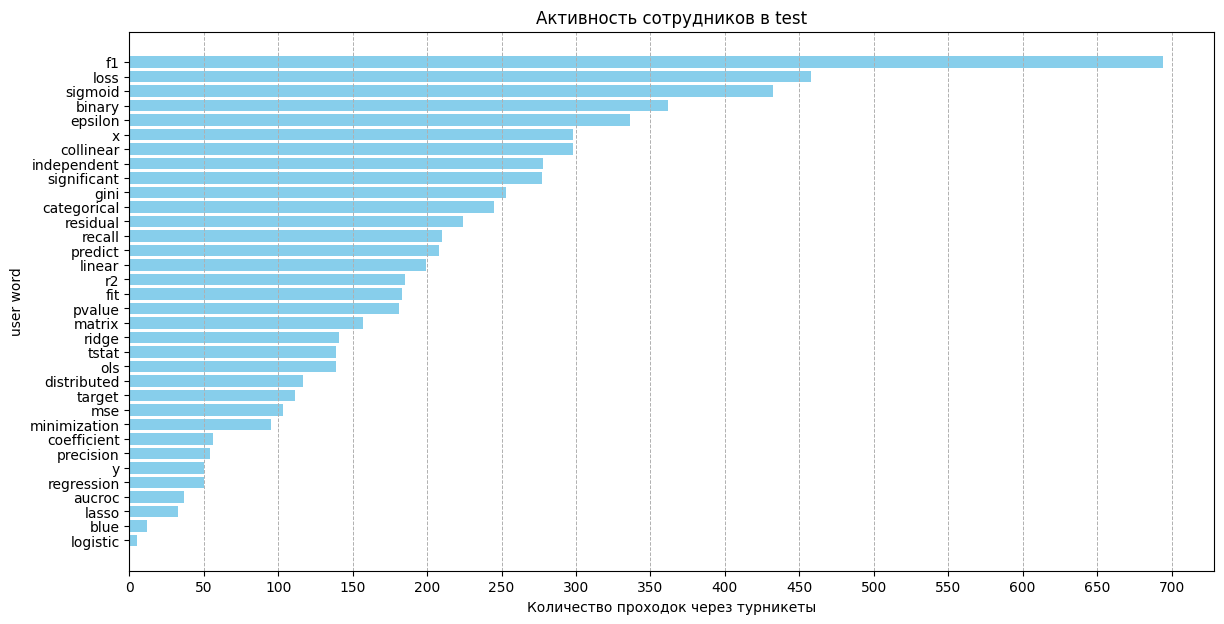

In [229]:
plt.figure(figsize=(14, 7))
plt.barh(count_user_word.index.astype(str), count_user_word['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user word')
plt.title('Активность сотрудников в test')
plt.xticks(np.arange(0, 750, 50))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Турникеты

In [230]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 17


gate_id,14,0,16,1,8,-1,15,12,13,6,9,7,11,5,10,3,4
count,1,2,3,5,15,23,298,378,720,1309,1440,2406,3356,3716,3905,4013,6380


In [231]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 16


gate_id,14,-1,1,2,8,15,12,6,13,9,7,11,5,3,10,4
count,1,1,2,4,10,102,120,282,310,394,540,762,853,893,915,1431


In [232]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [233]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [234]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [235]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [236]:
df_test.shape

(6612, 3)

# Генерирование признаков

In [237]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1 секунде
    df['repeat_gate_1s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(1)
    # -//- 2 секундам
    df['repeat_gate_2s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(2)
    # -//- 3 секундам
    df['repeat_gate_3s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(3)
    # -//- 4 секундам
    df['repeat_gate_4s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(4)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями равен 1 секунде
    df['cnt_repeat_gate_1s'] = grouped_data['repeat_gate_1s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_2s'] = grouped_data['repeat_gate_2s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_3s'] = grouped_data['repeat_gate_3s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_4s'] = grouped_data['repeat_gate_4s'].transform('sum')
    # -//- от 5 секунд
    df['cnt_repeat_gate_ge_5s'] = grouped_data['repeat_gate_ge_5s'].transform('sum')

    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')

    return df

In [238]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,0,2022-07-29 10:30:17,3,2022-07-29,29,10,630,37817,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,-100,3,-1000,-1,-100,11,-1000,-10144,-100,6,-1000,-10171,-100,6,-1000,-10172,-100,7,-1000,-13798,False,False,False,False,False,2,2,0,0,0,not_route,0,0,0,3,3,"[3, 3]","[3, 3]",0.00,0.00
1,0,2022-07-29 10:30:18,3,2022-07-29,29,10,630,37818,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,11,1,-10143,-100,6,-1000,-10170,-100,6,-1000,-10171,-100,7,-1000,-13797,-100,3,-1000,-13868,True,False,False,False,False,2,2,0,0,0,"[3, 3]",1,1,1,3,3,"[3, 3]","[3, 3]",1.50,1.92
2,0,2022-07-29 13:19:21,11,2022-07-29,29,13,799,47961,30,4,False,afternoon,False,False,12,2,0.17,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,6,10143,-27,3,6,10144,-28,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,3,-1000,-3727,False,False,False,False,False,2,2,0,0,0,"[3, 11]",10143,10144,10143,3,3,"[3, 3]","[3, 3]","10,143.00","12,404.29"


In [239]:
df_train.shape

(27936, 68)

In [240]:
# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,4,11,667,40020,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,-100,9,-1000,-164,-100,5,-1000,-174,-100,5,-1000,-175,-100,10,-1000,-192,-100,11,-1000,-25885,False,False,False,False,False,1,1,0,0,0,not_route,0,0,0,15,5,not_route,not_route,0.00,0.00
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,4,11,669,40184,1,2,False,morning,False,False,9,1,0.11,21,27,0.78,2,667,1103,436,15,15,632,0.69,15,5,164,-10,-100,5,-1000,-11,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,False,False,False,False,False,1,1,0,0,0,"[9, 15]",164,164,164,15,5,not_route,not_route,164.00,211.33
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,4,11,669,40194,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,9,5,10,-1,15,10,174,-18,-100,11,-1000,-25711,-100,4,-1000,-25736,-100,4,-1000,-25738,False,False,False,False,False,1,1,0,0,0,"[5, 9]",10,174,10,15,5,not_route,not_route,14.50,14.50


In [241]:
df_test.shape

(6612, 68)

In [242]:
df_train.isna().sum().sum()

0

In [243]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

## Повторное срабатывание турникетов

## Количество проходов через турникеты в неделю

In [244]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

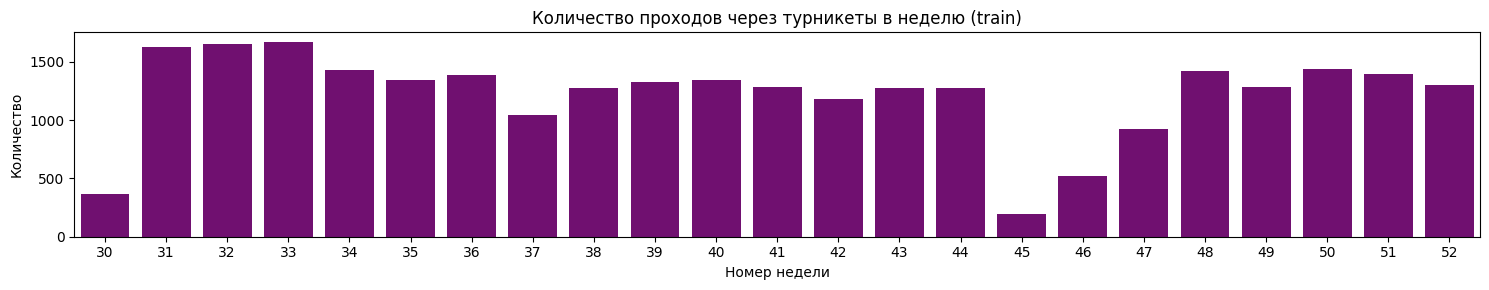

In [245]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [246]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [247]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

In [248]:
df_train.loc[df_train['week_number'] == 45, 'user_id'].unique()

array([ 0,  1,  6, 12, 14, 15, 17, 32, 35, 37, 46, 49, 50, 54],
      dtype=int64)

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [249]:
df_train.shape

(27936, 68)

In [250]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(27378, 68)

In [251]:
# df_train = df_train.query('week_number > 30').reset_index(drop=True)
# df_train.shape

In [252]:
df_train['user_id'].nunique()

31

In [253]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

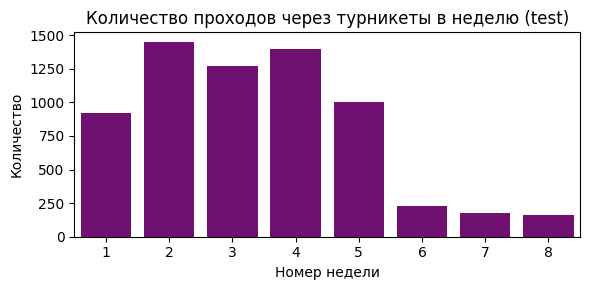

In [254]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [255]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [256]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

In [257]:
df_test.query('week_number >= 6')['user_id'].nunique()

20

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [258]:
df_test.shape

(6612, 68)

In [259]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(6040, 68)

In [260]:
df_test['user_id'].nunique()

34

In [261]:
# посмотрим распределение классов зависимой переменной
df_train['user_id'].value_counts(normalize=True)

user_id
37   0.08
55   0.08
12   0.07
6    0.07
19   0.06
15   0.06
11   0.05
0    0.04
33   0.04
1    0.04
49   0.04
39   0.04
9    0.04
32   0.04
54   0.03
50   0.03
29   0.03
3    0.03
17   0.02
14   0.02
35   0.02
46   0.02
24   0.01
26   0.01
23   0.01
25   0.01
56   0.00
43   0.00
22   0.00
36   0.00
2    0.00
Name: proportion, dtype: float64

In [262]:
df_train['user_id'].value_counts()

user_id
37    2137
55    2129
12    1802
6     1795
19    1631
15    1612
11    1254
0     1166
33    1160
1     1149
49    1094
39    1025
9     1015
32    1006
54     957
50     940
29     887
3      879
17     633
14     608
35     541
46     449
24     364
26     261
23     243
25     232
56     123
43     117
22      87
36      43
2       39
Name: count, dtype: int64

In [263]:
df_test['user_id'].value_counts(normalize=True)

user_id
f1             0.10
loss           0.07
sigmoid        0.06
binary         0.05
epsilon        0.05
x              0.05
significant    0.04
collinear      0.04
independent    0.04
residual       0.04
linear         0.03
predict        0.03
gini           0.03
fit            0.03
pvalue         0.03
recall         0.03
categorical    0.03
r2             0.03
ridge          0.02
tstat          0.02
ols            0.02
matrix         0.02
distributed    0.02
target         0.02
minimization   0.02
mse            0.01
coefficient    0.01
regression     0.01
y              0.01
precision      0.01
aucroc         0.01
lasso          0.01
blue           0.00
logistic       0.00
Name: proportion, dtype: float64

In [264]:
df_test['user_id'].value_counts()

user_id
f1              633
loss            447
sigmoid         390
binary          329
epsilon         303
x               277
significant     268
collinear       252
independent     234
residual        224
linear          199
predict         192
gini            186
fit             183
pvalue          181
recall          177
categorical     171
r2              170
ridge           141
tstat           139
ols             139
matrix          132
distributed     117
target          111
minimization     95
mse              89
coefficient      56
regression       42
y                40
precision        38
aucroc           35
lasso            33
blue             12
logistic          5
Name: count, dtype: int64

In [265]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [266]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [267]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27378 entries, 0 to 27377
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       27378 non-null  int64  
 1   gate_id                       27378 non-null  int64  
 2   day_of_month                  27378 non-null  int32  
 3   hour                          27378 non-null  int32  
 4   total_minutes                 27378 non-null  int32  
 5   total_seconds                 27378 non-null  int32  
 6   day_of_week                   27378 non-null  int32  
 7   is_weekend                    27378 non-null  bool   
 8   time_of_day                   27378 non-null  object 
 9   is_month_start                27378 non-null  bool   
 10  is_month_end                  27378 non-null  bool   
 11  pass_cnt_per_day              27378 non-null  int64  
 12  daily_gate_pass_count         27378 non-null  int64  
 13  p

In [268]:
df_train.columns

Index(['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes',
       'total_seconds', 'day_of_week', 'is_weekend', 'time_of_day',
       'is_month_start', 'is_month_end', 'pass_cnt_per_day',
       'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day',
       'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week',
       'entry_time', 'working_time_per_day', 'entrance_gate_id',
       'exit_gate_id', 'working_time_per_week', 'daily_workload_index',
       'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1',
       'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2',
       'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3',
       'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4',
       'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5',
       'repeat_gate_1s', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s',
       'cnt_repeat_gate_3s

In [269]:
categorical_features = [
       'gate_id', 'day_of_month', 'hour',
       'day_of_week', 'is_weekend', 'time_of_day', 
       'is_month_start', 'is_month_end', 'entrance_gate_id', 
       'exit_gate_id', 'gate_id_lag_1', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s',
       'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]

In [270]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27378 entries, 0 to 27377
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       27378 non-null  int64  
 1   gate_id                       27378 non-null  int64  
 2   day_of_month                  27378 non-null  int32  
 3   hour                          27378 non-null  int32  
 4   total_minutes                 27378 non-null  int32  
 5   total_seconds                 27378 non-null  int32  
 6   day_of_week                   27378 non-null  int32  
 7   is_weekend                    27378 non-null  bool   
 8   time_of_day                   27378 non-null  object 
 9   is_month_start                27378 non-null  bool   
 10  is_month_end                  27378 non-null  bool   
 11  pass_cnt_per_day              27378 non-null  int64  
 12  daily_gate_pass_count         27378 non-null  int64  
 13  p

## Оценка важности признаков

### Корреляция между признаками

In [70]:
%%time
phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
phik_overview

interval columns not set, guessing: ['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes', 'total_seconds', 'day_of_week', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'entrance_gate_id', 'exit_gate_id', 'working_time_per_week', 'daily_workload_index', 'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1', 'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s', 'cnt_repeat_gate_3s', 'cnt_repeat_gate_4s', 'cnt_repeat_gate_ge_5s', 'cumtime_per_day', 'cumtime_at_route_per_day', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'weekly_route_avg_time', 'route_avg_time']
CPU times: total: 6.05 

,user_id,gate_id,day_of_month,hour,total_minutes,total_seconds,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
user_id,1.00,0.41,0.14,0.45,0.45,0.45,0.16,0.09,0.23,0.06,0.08,0.56,0.30,0.16,0.15,0.24,0.12,0.53,0.59,0.55,0.58,0.41,0.73,0.59,0.22,0.07,0.21,0.21,0.24,0.11,0.28,0.28,0.25,0.14,0.33,0.33,0.26,0.17,0.35,0.35,0.27,0.20,0.35,0.35,0.12,0.08,0.10,0.06,0.17,0.38,0.48,0.35,0.23,0.31,0.51,0.29,0.18,0.53,0.57,0.71,0.73,0.26,0.40
most_frequent_route_per_week,0.73,0.43,0.35,0.26,0.26,0.26,0.18,0.17,0.23,0.12,0.07,0.51,0.33,0.24,0.29,0.46,0.23,0.53,0.46,0.41,0.44,0.41,0.60,0.37,0.31,0.09,0.14,0.14,0.33,0.13,0.19,0.19,0.35,0.17,0.23,0.23,0.37,0.21,0.25,0.25,0.38,0.24,0.27,0.27,0.12,0.08,0.09,0.04,0.32,0.62,0.38,0.32,0.19,0.64,0.61,0.23,0.14,0.82,0.89,0.91,1.00,0.22,0.29
working_time_per_week,0.73,0.17,0.31,0.43,0.38,0.38,0.15,0.14,0.17,0.14,0.06,0.44,0.20,0.17,0.18,0.46,0.20,0.73,0.69,0.72,0.36,0.29,1.00,0.78,0.09,0.05,0.10,0.10,0.11,0.08,0.15,0.15,0.12,0.10,0.19,0.19,0.14,0.13,0.21,0.21,0.14,0.14,0.23,0.23,0.07,0.02,0.10,0.05,0.04,0.25,0.26,0.25,0.15,0.17,0.22,0.39,0.20,0.30,0.38,0.52,0.60,0.16,0.20
most_frequent_route_per_day,0.71,0.52,0.36,0.34,0.34,0.34,0.41,0.28,0.33,0.14,0.23,0.70,0.52,0.42,0.42,0.41,0.39,0.37,0.45,0.50,0.59,0.53,0.52,0.38,0.35,0.15,0.22,0.22,0.39,0.22,0.31,0.31,0.42,0.29,0.37,0.37,0.46,0.35,0.39,0.39,0.48,0.40,0.39,0.39,0.13,0.07,0.08,0.03,0.39,0.68,0.52,0.41,0.21,0.69,0.68,0.33,0.19,0.89,0.78,1.00,0.91,0.25,0.29
daily_workload_index,0.59,0.13,0.34,0.17,0.17,0.17,0.38,0.56,0.07,0.10,0.09,0.34,0.17,0.14,0.41,0.32,0.42,0.84,0.44,0.66,0.35,0.23,0.78,1.00,0.05,0.05,0.07,0.07,0.07,0.07,0.12,0.12,0.09,0.09,0.14,0.14,0.11,0.11,0.15,0.15,0.12,0.13,0.16,0.16,0.03,0.02,0.04,0.03,0.02,0.18,0.31,0.16,0.19,0.14,0.17,0.23,0.07,0.24,0.17,0.38,0.37,0.07,0.14
entry_time,0.59,0.15,0.24,0.68,0.65,0.65,0.28,0.39,0.34,0.05,0.08,0.41,0.18,0.28,0.33,0.31,0.32,0.22,1.00,0.77,0.23,0.23,0.69,0.44,0.11,0.06,0.16,0.16,0.12,0.10,0.23,0.23,0.14,0.12,0.28,0.28,0.16,0.15,0.28,0.28,0.18,0.17,0.29,0.29,0.07,0.03,0.12,0.09,0.04,0.26,0.37,0.38,0.18,0.12,0.24,0.37,0.18,0.29,0.28,0.45,0.46,0.14,0.19
entrance_gate_id,0.58,0.46,0.16,0.16,0.16,0.16,0.11,0.06,0.09,0.04,0.03,0.29,0.09,0.22,0.11,0.23,0.09,0.23,0.23,0.25,1.00,0.64,0.36,0.35,0.13,0.02,0.05,0.05,0.13,0.03,0.08,0.08,0.14,0.04,0.09,0.09,0.13,0.05,0.10,0.10,0.12,0.05,0.12,0.12,0.03,0.02,0.01,0.01,0.01,0.13,0.20,0.10,0.06,0.12,0.45,0.13,0.05,0.53,0.37,0.59,0.44,0.05,0.11
most_frequent_gate_per_week,0.57,0.37,0.20,0.18,0.19,0.19,0.09,0.10,0.14,0.04,0.07,0.35,0.29,0.19,0.15,0.29,0.15,0.19,0.28,0.25,0.37,0.49,0.38,0.17,0.20,0.04,0.10,0.10,0.20,0.06,0.13,0.13,0.21,0.08,0.15,0.15,0.21,0.10,0.16,0.16,0.19,0.12,0.17,0.17,0.10,0.05,0.05,0.02,0.29,0.46,0.18,0.14,0.08,0.45,0.56,0.13,0.11,0.76,1.00,0.78,0.89,0.14,0.21
pass_cnt_per_day,0.56,0.24,0.35,0.26,0.26,0.26,0.19,0.10,0.23,0.16,0.19,1.00,0.74,0.22,0.21,0.33,0.17,0.23,0.41,0.57,0.29,0.20,0.44,0.34,0.18,0.18,0.25,0.25,0.25,0.26,0.35,0.35,0.31,0.34,0.41,0.41,0.36,0.41,0.43,0.43,0.40,0.47,0.46,0.46,0.06,0.03,0.07,0.02,0.08,0.75,0.78,0.40,0.17,0.50,0.32,0.30,0.18,0.45,0.35,0.70,0.51,0.24,0.25
work

In [71]:
# # отберем фичи, у которых корреляция с целевым признаком более 0.2
# df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [72]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [73]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [74]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [271]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27378 entries, 0 to 27377
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       27378 non-null  int64  
 1   gate_id                       27378 non-null  int64  
 2   day_of_month                  27378 non-null  int32  
 3   hour                          27378 non-null  int32  
 4   total_minutes                 27378 non-null  int32  
 5   total_seconds                 27378 non-null  int32  
 6   day_of_week                   27378 non-null  int32  
 7   is_weekend                    27378 non-null  bool   
 8   time_of_day                   27378 non-null  object 
 9   is_month_start                27378 non-null  bool   
 10  is_month_end                  27378 non-null  bool   
 11  pass_cnt_per_day              27378 non-null  int64  
 12  daily_gate_pass_count         27378 non-null  int64  
 13  p

In [272]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [273]:
categorical_columns = categorical_features
print(categorical_columns)

['gate_id', 'day_of_month', 'hour', 'day_of_week', 'is_weekend', 'time_of_day', 'is_month_start', 'is_month_end', 'entrance_gate_id', 'exit_gate_id', 'gate_id_lag_1', 'gate_id_1', 'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s', 'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week']


In [274]:
len(categorical_columns)

30

In [275]:
numerical_columns = list(set(X.columns) - set(categorical_columns))
print(numerical_columns)

['cnt_repeat_gate_2s', 'cnt_repeat_gate_ge_5s', 'cnt_users_per_week', 'sec_btw_lag_2', 'sec_btw_5', 'total_seconds', 'sec_btw_lag_1', 'working_time_per_week', 'sec_btw_lag_3', 'sec_btw_2', 'cumtime_per_day', 'cumtime_at_route_per_day', 'cnt_repeat_gate_4s', 'probability_gate_id', 'total_minutes', 'sec_btw_lag_5', 'cnt_repeat_gate_3s', 'sec_btw_4', 'route_avg_time', 'daily_workload_index', 'daily_gate_pass_count', 'sec_btw_3', 'sec_btw_lag_4', 'daily_attendance_index', 'cnt_days_per_week', 'cnt_repeat_gate_1s', 'entry_time', 'sec_btw_1', 'pass_cnt_per_day', 'weekly_route_avg_time', 'working_time_per_day', 'cnt_users_per_day']


In [276]:
len(numerical_columns)

32

In [277]:
X = X[categorical_columns + numerical_columns]

In [278]:
# # формируем массив индексов категориальных признаков
# categorical_features_indices = np.where(X.dtypes == 'category')[0]
# categorical_features_indices

In [279]:
# формируем массив индексов категориальных признаков
categorical_features_indices = list(range(len(categorical_columns)))
print(categorical_features_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [280]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [281]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21902, 62), (5476, 62), (21902,), (5476,))

In [282]:
y_train.nunique()

31

In [283]:
print(sorted(y_train.unique()))

[0, 1, 2, 3, 6, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 29, 32, 33, 35, 36, 37, 39, 43, 46, 49, 50, 54, 55, 56]


In [284]:
y_test.nunique()

31

In [285]:
print(sorted(y_test.unique()))

[0, 1, 2, 3, 6, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 29, 32, 33, 35, 36, 37, 39, 43, 46, 49, 50, 54, 55, 56]


## Подбор гиперпараметров

In [90]:
def fit_catboost(trial, train, val, cat_features_indices):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_estimators' : 2000, # Можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features_indices,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [91]:
def objective(trial, X, y, cat_features_indices, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features_indices) # Определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='macro'))
        models.append(model)
        # break
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [92]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X, y, categorical_features_indices),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-14 15:24:28,695] A new study created in memory with name: no-name-527a4bc5-a4fb-4ce4-b77e-5329c947623e


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.3449519	test: 0.3330078	best: 0.3330078 (0)	total: 110ms	remaining: 3m 39s
100:	learn: 0.9176099	test: 0.9162206	best: 0.9162206 (100)	total: 12.1s	remaining: 3m 47s
200:	learn: 0.9672035	test: 0.9642352	best: 0.9642352 (199)	total: 22.6s	remaining: 3m 22s
300:	learn: 0.9824666	test: 0.9775043	best: 0.9775043 (300)	total: 32s	remaining: 3m
400:	learn: 0.9894955	test: 0.9836765	best: 0.9836765 (399)	total: 40.8s	remaining: 2m 42s
500:	learn: 0.9923921	test: 0.9884169	best: 0.9884169 (498)	total: 49.1s	remaining: 2m 26s
600:	learn: 0.9940384	test: 0.9905924	best: 0.9906711 (592)	total: 57.4s	remaining: 2m 13s
700:	learn: 0.9946214	test: 0.9918239	best: 0.9918239 (696)	total: 1m 5s	remaining: 2m
800:	learn: 0.9953593	test: 0.9925894	best: 0.9926667 (789)	total: 1m 13s	remaining: 1m 49s
900:	learn: 0.9958300	test: 0.9929128	best: 0.9929128 (897)	total: 1m 20s	remaining: 1m 38s
1000:	learn: 0.9964273	test: 0.9934705	best: 0.9935489 (995)	total: 1m 28s	remaining: 1m 28s
1100:	lea

In [93]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9966736309138803, params {'learning_rate': 0.04031923286563071, 'l2_leaf_reg': 27.23443154592482, 'auto_class_weights': 'Balanced', 'max_depth': 8, 'border_count': 73}


In [94]:
%%time

valid_scores, models_all_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X, 
    y, 
    categorical_features_indices,
    return_models=True,
)

0:	learn: 0.3449519	test: 0.3330078	best: 0.3330078 (0)	total: 207ms	remaining: 6m 53s
100:	learn: 0.9176099	test: 0.9162206	best: 0.9162206 (100)	total: 20.3s	remaining: 6m 21s
200:	learn: 0.9672035	test: 0.9642352	best: 0.9642352 (199)	total: 38.9s	remaining: 5m 47s
300:	learn: 0.9824666	test: 0.9775043	best: 0.9775043 (300)	total: 56.3s	remaining: 5m 18s
400:	learn: 0.9894955	test: 0.9836765	best: 0.9836765 (399)	total: 1m 13s	remaining: 4m 52s
500:	learn: 0.9923921	test: 0.9884169	best: 0.9884169 (498)	total: 1m 29s	remaining: 4m 28s
600:	learn: 0.9940384	test: 0.9905924	best: 0.9906711 (592)	total: 1m 46s	remaining: 4m 6s
700:	learn: 0.9946214	test: 0.9918239	best: 0.9918239 (696)	total: 2m 1s	remaining: 3m 45s
800:	learn: 0.9953593	test: 0.9925894	best: 0.9926667 (789)	total: 2m 17s	remaining: 3m 26s
900:	learn: 0.9958300	test: 0.9929128	best: 0.9929128 (897)	total: 2m 33s	remaining: 3m 7s
1000:	learn: 0.9964273	test: 0.9934705	best: 0.9935489 (995)	total: 2m 49s	remaining: 2m 48

In [118]:
models_all_features

In [120]:
valid_scores, len(models_all_features)

(0.9966736309138803, 3)

In [121]:
for m in models_all_features:
    print(m.tree_count_)

1872
1281
1752


In [122]:
for m in models_all_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 27.234432220458984, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storag

## Важность признаков

### Feature Importance

In [167]:
# models_all_features[1].get_feature_importance(prettified=True)

In [119]:
# feature_importance = models_all_features[1].feature_importances_
# sorted_idx = np.argsort(feature_importance)

In [105]:
# plt.figure(figsize=(15, 15))
# plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance in CatBoostClassifier')
# plt.grid(axis='x', linestyle='--', linewidth=0.7)

### SHAP values

## Отбор признаков

In [165]:
# создаем список имен признаков
feature_names = list(X_train.columns)

# создаем список категориальных признаков
cat_features = categorical_columns

# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=cat_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=cat_features)

In [166]:
study.best_params

{'learning_rate': 0.04031923286563071,
 'l2_leaf_reg': 27.23443154592482,
 'auto_class_weights': 'Balanced',
 'max_depth': 8,
 'border_count': 73}

In [168]:
# пишем функцию отбора признаков на основе 
# рекурсивного удаления признаков
def catboost_select_features(
    algorithm: EFeaturesSelectionAlgorithm, 
    steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    **study.best_params,
                    n_estimators=1700,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    eval_metric='TotalF1:average=Macro',
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=3,
        # количество итераций обучения модели, вычисляющей 
        # оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [169]:
%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['most_frequent_route_per_week', 'working_time_per_week', 'entry_time']
CPU times: total: 3h 21min 29s
Wall time: 28min 41s


In [170]:
print(shap_summary['loss_graph'])

{'main_indices': [0, 28, 44, 52, 57, 59], 'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'loss_values': [0.060378571522252004, 0.062250110913754826, 0.06271108891701281, 0.06271108891701281, 0.06271108891701314, 0.06271108891701314, 0.06271108891701314, 0.06271108891701314, 0.06271108891701314, 0.06271108891701281, 0.06266546121820198, 0.06261669094830506, 0.06252674892371946, 0.06235644580032036, 0.06217025798230734, 0.06197239094913303, 0.061734014204021435, 0.06104860933895895, 0.06030868605391973, 0.05955939904593538, 0.05857920243865402, 0.05758005829967163, 0.05638705595981157, 0.05492517626699326, 0.05341538677295206, 0.05123636712926125, 0.04870804159742036, 0.04600917739998013, 0.04346418892784901, 0.04345589612560278, 0.04344730917528754, 0.04342979175620038, 0.0434041

In [171]:
shap_summary['loss_graph']['loss_values'][-1]

0.22580296759507684

In [172]:
# печатаем отобранные признаки
selected_feat = shap_summary['selected_features_names']
print(selected_feat)

['most_frequent_route_per_week', 'working_time_per_week', 'entry_time']


In [173]:
# печатаем исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']
print(eliminated_feat)

['sec_btw_lag_1', 'repeat_gate_1s', 'gate_id', 'hour', 'gate_id_2', 'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s', 'route', 'gate_id_4', 'gate_id_lag_5', 'day_of_month', 'gate_id_lag_3', 'gate_id_lag_4', 'gate_id_3', 'repeat_gate_ge_5s', 'sec_btw_lag_4', 'time_of_day', 'daily_gate_pass_count', 'is_month_start', 'gate_id_5', 'sec_btw_lag_2', 'total_minutes', 'sec_btw_1', 'is_month_end', 'cumtime_at_route_per_day', 'sec_btw_3', 'sec_btw_lag_5', 'gate_id_1', 'sec_btw_4', 'cumtime_per_day', 'gate_id_lag_2', 'sec_btw_5', 'is_weekend', 'total_seconds', 'cnt_repeat_gate_4s', 'sec_btw_lag_3', 'day_of_week', 'gate_id_lag_1', 'sec_btw_2', 'weekly_route_avg_time', 'probability_gate_id', 'cnt_repeat_gate_ge_5s', 'most_frequent_gate_per_day', 'cnt_users_per_day', 'cnt_repeat_gate_3s', 'most_frequent_route_per_day', 'route_avg_time', 'daily_attendance_index', 'cnt_repeat_gate_2s', 'exit_gate_id', 'daily_workload_index', 'cnt_repeat_gate_1s', 'entrance_gate_id', 'working_time_per_day', 'pass_c

На основе графика `Loss by eliminated features`, отберем из списка `eliminated_feat` фичи, начиная с 44-го индекса.

In [176]:
selected_features = selected_feat + eliminated_feat[44:]
selected_features

['most_frequent_route_per_week',
 'working_time_per_week',
 'entry_time',
 'cnt_users_per_day',
 'cnt_repeat_gate_3s',
 'most_frequent_route_per_day',
 'route_avg_time',
 'daily_attendance_index',
 'cnt_repeat_gate_2s',
 'exit_gate_id',
 'daily_workload_index',
 'cnt_repeat_gate_1s',
 'entrance_gate_id',
 'working_time_per_day',
 'pass_cnt_per_day',
 'cnt_users_per_week',
 'cnt_days_per_week',
 'most_frequent_gate_per_week']

In [177]:
len(selected_features)

18

In [178]:
cat_features = [
    'most_frequent_route_per_week',
    'most_frequent_route_per_day',
    'exit_gate_id',
    'entrance_gate_id',
    'most_frequent_gate_per_week'
]

In [182]:
%%time

valid_scores, models_selected_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.3449519	test: 0.3330078	best: 0.3330078 (0)	total: 121ms	remaining: 4m 2s
100:	learn: 0.8739863	test: 0.8638938	best: 0.8638938 (100)	total: 10.5s	remaining: 3m 17s
200:	learn: 0.9601059	test: 0.9552637	best: 0.9552637 (200)	total: 20.9s	remaining: 3m 7s
300:	learn: 0.9835113	test: 0.9773645	best: 0.9774682 (297)	total: 30.3s	remaining: 2m 50s
400:	learn: 0.9894649	test: 0.9842931	best: 0.9842931 (400)	total: 38.5s	remaining: 2m 33s
500:	learn: 0.9923083	test: 0.9889354	best: 0.9889960 (494)	total: 46.6s	remaining: 2m 19s
600:	learn: 0.9951486	test: 0.9935598	best: 0.9935617 (594)	total: 54.9s	remaining: 2m 7s
700:	learn: 0.9966447	test: 0.9947041	best: 0.9947041 (693)	total: 1m 3s	remaining: 1m 57s
800:	learn: 0.9978435	test: 0.9954560	best: 0.9954560 (787)	total: 1m 11s	remaining: 1m 46s
900:	learn: 0.9986709	test: 0.9967866	best: 0.9967866 (894)	total: 1m 19s	remaining: 1m 37s
1000:	learn: 0.9987704	test: 0.9972654	best: 0.9972654 (931)	total: 1m 27s	remaining: 1m 27s
11

In [183]:
valid_scores

0.9977749314470513

In [185]:
for m in models_selected_features:
    print(m.tree_count_)

1522
1062
1325


In [192]:
for m in models_selected_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 27.234432220458984, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storag

## Подбор гиперпараметров после отбора признаков

In [286]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=5,
                show_progress_bar=True,
)

[I 2024-08-14 20:25:46,084] A new study created in memory with name: no-name-ae735bee-591e-4711-8f67-78ead7899ea4


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.5120311	test: 0.4962075	best: 0.4962075 (0)	total: 330ms	remaining: 10m 59s
100:	learn: 0.9318659	test: 0.9249244	best: 0.9249244 (100)	total: 25.6s	remaining: 8m 1s
200:	learn: 0.9901533	test: 0.9874677	best: 0.9874677 (196)	total: 48.6s	remaining: 7m 14s
300:	learn: 0.9959134	test: 0.9938779	best: 0.9938779 (285)	total: 1m 11s	remaining: 6m 43s
400:	learn: 0.9980723	test: 0.9966054	best: 0.9966054 (394)	total: 1m 32s	remaining: 6m 7s
500:	learn: 0.9988756	test: 0.9980029	best: 0.9980029 (483)	total: 1m 52s	remaining: 5m 36s
600:	learn: 0.9994448	test: 0.9991288	best: 0.9991288 (598)	total: 2m 13s	remaining: 5m 9s
700:	learn: 0.9997169	test: 0.9997318	best: 0.9997318 (686)	total: 2m 33s	remaining: 4m 44s
bestTest = 0.9997318185
bestIteration = 686
Shrink model to first 687 iterations.
0:	learn: 0.5169725	test: 0.5048728	best: 0.5048728 (0)	total: 411ms	remaining: 13m 42s
100:	learn: 0.9524290	test: 0.9427776	best: 0.9427776 (100)	total: 37.3s	remaining: 11m 42s
200:	learn:

In [287]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9986881999044241, params {'learning_rate': 0.04325415489908707, 'l2_leaf_reg': 18.338330868742815, 'auto_class_weights': 'Balanced', 'max_depth': 10, 'border_count': 84}


In [288]:
%%time

valid_scores, models_sf_new_fit = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.5120311	test: 0.4962075	best: 0.4962075 (0)	total: 327ms	remaining: 10m 52s
100:	learn: 0.9318659	test: 0.9249244	best: 0.9249244 (100)	total: 25.6s	remaining: 8m 1s
200:	learn: 0.9901533	test: 0.9874677	best: 0.9874677 (196)	total: 48.8s	remaining: 7m 16s
300:	learn: 0.9959134	test: 0.9938779	best: 0.9938779 (285)	total: 1m 11s	remaining: 6m 44s
400:	learn: 0.9980723	test: 0.9966054	best: 0.9966054 (394)	total: 1m 31s	remaining: 6m 6s
500:	learn: 0.9988756	test: 0.9980029	best: 0.9980029 (483)	total: 1m 52s	remaining: 5m 35s
600:	learn: 0.9994448	test: 0.9991288	best: 0.9991288 (598)	total: 2m 12s	remaining: 5m 8s
700:	learn: 0.9997169	test: 0.9997318	best: 0.9997318 (686)	total: 2m 32s	remaining: 4m 42s
bestTest = 0.9997318185
bestIteration = 686
Shrink model to first 687 iterations.
0:	learn: 0.5169725	test: 0.5048728	best: 0.5048728 (0)	total: 288ms	remaining: 9m 36s
100:	learn: 0.9524290	test: 0.9427776	best: 0.9427776 (100)	total: 25s	remaining: 7m 49s
200:	learn: 0.9

In [289]:
valid_scores

0.9987588005955305

In [290]:
for m in models_sf_new_fit:
    print(m.tree_count_)

687
539
882


In [291]:
for m in models_sf_new_fit:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 18.33833122253418, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Итоговое предсказание лучшей модели

In [99]:
def make_prediction_dict(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [154]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [293]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Вариант Ивана

In [102]:
# выбор ответа для конкретного user_word
def choosing_answer(votes):
    votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)
    
    if len(votes) == 1:                 # если существует единственный вариант ответа
        return votes[0]                 # возвращаем ответ и число голосов
    if votes[0][1] == votes[1][1]:      # если первые два места равны
        return -999, 100                # ответ со 100% неопределен
    return votes[0]


# функция отбора голосов
def vote_processing(d):
    word_to_id = {}
    id_to_word = {}
    result = []

    for user_word, votes in d.items():
        user_id, num = choosing_answer(votes)           # получили ответ и количество голосов
        result.append(tuple([user_word, user_id, num]))

    # отсортируем список по уверенности в ответе
    result = sorted(result, key=lambda x: x[2], reverse=True)

    # проверим список на наличие дубликатов:
    for user_word, user_id, number_of_votes in result:
        # ситуация, когда ответ user_id неопознан или уже есть (и его приоритет ниже, так как список отсортирован по убыванию уверенности)
        if user_id == -999 or user_id in id_to_word:
            word_to_id[user_word] = -999
            continue
        word_to_id[user_word] = user_id
        id_to_word[user_id] = user_word

    # сохраним в требуемом формате
    df = pd.Series(word_to_id).to_frame().reset_index()
    df.columns = ['user_word', 'preds']
    df = df.groupby('user_word')['preds'].first().to_frame()
    return df

для отладки

In [132]:
# из тестового набора выделяем фичи, на которых обучались
X_temp = df_test.loc[:, X.columns]
# датафрейм с закодированными user_id из тестовой выборки
res = df_test.loc[:, ['user_word']]
# делаем предсказания user_id
predictions = np.array([model.predict(X_temp) for model in models_all_features])
res['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
res

,user_word,pred_user_id
0,gini,15
1,gini,15
2,gini,15
3,gini,15
4,epsilon,26
...,...,...
6035,binary,14
6036,binary,14
6037,binary,14
6038,binary,14


In [133]:
# датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
temp_1 = res.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
temp_1.head()

,user_word,pred_user_id,count_pred_user_id_in_user_word
0,aucroc,24,35
1,binary,9,9
2,binary,12,231
3,binary,14,25
4,binary,15,16


In [134]:
# датафрейм: user_word; количество user_word
temp_2 = res['user_word'].value_counts().reset_index(name='count_user_word')
temp_2.head()

,user_word,count_user_word
0,f1,633
1,loss,447
2,sigmoid,390
3,binary,329
4,epsilon,303


In [135]:
# датафрейм: pred_user_id; количество pred_user_id
temp_3 = res['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
temp_3.head()

,pred_user_id,count_pred_user_id
0,6,669
1,19,493
2,55,441
3,15,349
4,49,340


In [138]:
# датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
res = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
res.head()

,user_word,pred_user_id,count_pred_user_id_in_user_word,count_user_word,count_pred_user_id
0,aucroc,24,35,35,46
1,binary,9,9,329,62
2,binary,12,231,329,270
3,binary,14,25,329,217
4,binary,15,16,329,349


In [149]:
# добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
res['confidence_per_user_word'] = res['count_pred_user_id_in_user_word'] / res['count_user_word']
# добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
res['confidence_per_pred_user_id'] = res['count_pred_user_id_in_user_word'] / res['count_pred_user_id']
# итоговая уверенность
res['confidence'] = res['confidence_per_user_word'] + res['confidence_per_pred_user_id']
# сортируем данные по убыванию уверенности
res = res.sort_values(by='confidence', ascending=False)
res.head()

,user_word,pred_user_id,count_pred_user_id_in_user_word,count_user_word,count_pred_user_id,confidence_per_user_word,confidence_per_pred_user_id,confidence
0,aucroc,24,35,35,46,1.00,0.76,1.76
124,recall,3,153,177,187,0.86,0.82,1.68
35,f1,6,529,633,669,0.84,0.79,1.63
10,categorical,14,151,171,217,0.88,0.70,1.58
2,binary,12,231,329,270,0.70,0.86,1.56


In [150]:
# формируем итоговый датафрейм
final = pd.DataFrame(columns=['user_word', 'preds'])
# user_word, которые уже добавлены в final
words = set()
# user_id, которые уже добавлены в final
ids = set()
# добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
for _, row in res.iterrows():
    word, user_id = row['user_word'], row['pred_user_id']
    if word not in words and user_id not in ids and row['confidence'] > 0.1:
        final.loc[len(final)] = [word, user_id]
        words.add(word)
        ids.add(user_id)

# категориям, насчет которых модель не уверена, проставляется -999
for word in (set(res['user_word'].unique()) - set(final['user_word'])):
    final.loc[len(final)] = [word, -999]

final.sort_values(by='user_word')

,user_word,preds
0,aucroc,24
4,binary,12
9,blue,56
3,categorical,14
27,coefficient,22
22,collinear,33
10,distributed,0
16,epsilon,1
2,f1,6
24,fit,2


Сделаем предсказание

Используем все фичи

In [156]:
result_dct = make_prediction_dict(df_test, X.columns, models_all_features)
result_dct

{'aucroc': {24: 35},
 'binary': {12: 231, 14: 25, 43: 20, 29: 18, 15: 16, 49: 10, 9: 9},
 'blue': {56: 12},
 'categorical': {14: 151, 56: 19, 12: 1},
 'coefficient': {15: 40, 22: 9, 24: 7},
 'collinear': {33: 77,
  43: 51,
  46: 31,
  54: 31,
  0: 22,
  26: 15,
  35: 14,
  17: 5,
  23: 4,
  50: 2},
 'distributed': {0: 91, 11: 12, 22: 10, 24: 3, 35: 1},
 'epsilon': {49: 136, 1: 105, 26: 45, 55: 17},
 'f1': {6: 529, 37: 99, 1: 5},
 'fit': {15: 68, 23: 48, 2: 24, 0: 14, 1: 9, 43: 8, 46: 5, 50: 4, 19: 2, 3: 1},
 'gini': {15: 151, 39: 22, 0: 8, 1: 4, 3: 1},
 'independent': {39: 99, 14: 35, 15: 32, 49: 28, 1: 20, 2: 13, 43: 6, 24: 1},
 'lasso': {25: 18, 36: 5, 56: 5, 23: 5},
 'linear': {17: 65, 55: 47, 3: 29, 0: 29, 33: 22, 32: 7},
 'logistic': {56: 5},
 'loss': {19: 342, 46: 48, 15: 33, 49: 11, 54: 10, 43: 3},
 'matrix': {25: 27,
  32: 18,
  55: 18,
  37: 17,
  29: 13,
  2: 11,
  43: 11,
  41: 9,
  56: 7,
  15: 1},
 'minimization': {50: 61, 43: 16, 29: 9, 25: 4, 41: 3, 22: 2},
 'mse': {43: 

In [193]:
# vote_processing(result_dct)

In [158]:
result_cb = make_prediction(df_test, X.columns, models_all_features)
result_cb

,user_word,preds
0,aucroc,24
4,binary,12
9,blue,56
3,categorical,14
27,coefficient,22
22,collinear,33
10,distributed,0
16,epsilon,1
2,f1,6
24,fit,2


In [ ]:
len(result_cb)

После удаления фичей, уменьшающих скор

In [194]:
result_dct_sf = make_prediction_dict(df_test, selected_features, models_selected_features)
result_dct_sf

{'aucroc': {24: 35},
 'binary': {12: 222, 14: 25, 43: 22, 49: 22, 9: 19, 29: 18, 15: 1},
 'blue': {56: 12},
 'categorical': {14: 139, 56: 31, 12: 1},
 'coefficient': {15: 40, 22: 9, 24: 7},
 'collinear': {33: 77,
  43: 53,
  46: 45,
  54: 31,
  0: 19,
  35: 13,
  17: 5,
  29: 5,
  23: 4},
 'distributed': {0: 85, 35: 14, 11: 12, 55: 6},
 'epsilon': {1: 135, 49: 106, 26: 45, 55: 17},
 'f1': {6: 516, 37: 112, 1: 5},
 'fit': {15: 67, 23: 35, 2: 24, 0: 14, 11: 12, 1: 11, 43: 8, 50: 7, 46: 5},
 'gini': {15: 161, 39: 10, 49: 7, 0: 5, 25: 3},
 'independent': {39: 95, 49: 51, 14: 35, 2: 14, 12: 12, 1: 11, 15: 10, 43: 6},
 'lasso': {25: 17, 56: 5, 23: 5, 46: 4, 36: 2},
 'linear': {17: 65, 55: 40, 0: 34, 3: 31, 33: 21, 32: 7, 29: 1},
 'logistic': {56: 5},
 'loss': {19: 307, 6: 38, 15: 33, 11: 30, 46: 18, 54: 13, 49: 8},
 'matrix': {25: 27,
  29: 22,
  32: 19,
  35: 11,
  37: 11,
  41: 9,
  56: 8,
  11: 7,
  43: 7,
  54: 6,
  2: 4,
  3: 1},
 'minimization': {50: 61, 43: 18, 22: 11, 25: 4, 55: 1},


In [195]:
result_cb_sf = make_prediction(df_test, selected_features, models_selected_features)
result_cb_sf

,user_word,preds
0,aucroc,24
3,binary,12
11,blue,56
4,categorical,14
27,coefficient,22
23,collinear,33
13,distributed,0
9,epsilon,1
2,f1,6
24,fit,2


In [196]:
len(result_cb_sf)

34

После удаления фичей, уменьшающих скор, и повторного подбора гиперпараметров

29

In [294]:
result_dct_sf_new_fit = make_prediction_dict(df_test, selected_features, models_sf_new_fit)
result_dct_sf_new_fit

{'aucroc': {24: 35},
 'binary': {12: 211, 49: 35, 43: 29, 14: 25, 15: 20, 24: 8, 54: 1},
 'blue': {56: 12},
 'categorical': {14: 140, 56: 14, 43: 10, 24: 6, 12: 1},
 'coefficient': {15: 37, 6: 8, 25: 7, 46: 3, 22: 1},
 'collinear': {33: 76,
  43: 48,
  46: 34,
  0: 19,
  54: 19,
  23: 15,
  35: 13,
  29: 10,
  50: 7,
  17: 5,
  22: 5,
  6: 1},
 'distributed': {0: 66, 35: 14, 19: 13, 11: 12, 46: 12},
 'epsilon': {1: 217, 15: 45, 55: 17, 24: 14, 6: 4, 49: 3, 33: 2, 3: 1},
 'f1': {6: 472, 37: 144, 33: 12, 1: 5},
 'fit': {15: 72, 23: 35, 2: 24, 11: 19, 0: 14, 43: 8, 1: 5, 46: 5, 3: 1},
 'gini': {15: 151, 1: 11, 24: 8, 0: 8, 39: 7, 3: 1},
 'independent': {15: 78, 39: 62, 14: 35, 1: 20, 49: 19, 26: 14, 43: 6},
 'lasso': {46: 15, 25: 8, 56: 5, 23: 5},
 'linear': {17: 61, 55: 51, 3: 33, 33: 31, 0: 21, 32: 2},
 'logistic': {56: 5},
 'loss': {19: 225, 6: 73, 46: 48, 49: 41, 37: 19, 50: 14, 15: 14, 43: 13},
 'matrix': {32: 22,
  25: 20,
  29: 19,
  6: 16,
  2: 13,
  49: 9,
  56: 8,
  54: 8,
  43:

In [295]:
result_cb_sf_new_fit = make_prediction(df_test, selected_features, models_sf_new_fit)
result_cb_sf_new_fit

,user_word,preds
5,aucroc,24
1,binary,12
9,blue,56
2,categorical,14
30,coefficient,-999
18,collinear,22
17,distributed,0
0,epsilon,1
4,f1,6
21,fit,2


In [296]:
len(result_cb_sf_new_fit)

34

Сохраненим результаты

In [302]:
csv_buffer = io.StringIO()

# result_cb.to_csv(csv_buffer, index=False)

# result_cb_sf.to_csv(csv_buffer, index=False)

result_cb_sf_new_fit.to_csv(csv_buffer, index=False)

with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())

In [298]:
# result_cb.to_csv('../data/submit_cb_v_05_all.csv', index=False)

# result_cb_sf.to_csv('../data/submit_cb_v_05_sf.csv', index=False)

result_cb_sf_new_fit.to_csv('../data/submit_cb_v_05_sf_new_fit.csv', index=False)

# Сравнение ответов

In [299]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/submit_cb_v_01_264.csv')
res_cb_02 = pd.read_csv('../data/submit_cb_v_02.csv')
res_cb_03 = pd.read_csv('../data/submit_cb_v_03_270.csv')
res_cb_04 = pd.read_csv('../data/submit_cb_v_04.csv')
res_cb_05_all = pd.read_csv('../data/submit_cb_v_05_all_353.csv')
res_cb_05_sf = pd.read_csv('../data/submit_cb_v_05_sf.csv')
res_cb_05_sf_new_fit = pd.read_csv('../data/submit_cb_v_05_sf_new_fit.csv')

In [300]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_v_01_264'] = res_cb_01['preds']
res['cb_v_02'] = res_cb_02['preds']
res['cb_v_03_270'] = res_cb_03['preds']
res['cb_v_04'] = res_cb_04['preds']
res['cb_v_05_all_353'] = res_cb_05_all['preds']
res['cb_v_05_sf'] = res_cb_05_sf['preds']
res['cb_v_05_sf_new_fit'] = res_cb_05_sf_new_fit['preds']

In [301]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01_264,cb_v_02,cb_v_03_270,cb_v_04,cb_v_05_all_353,cb_v_05_sf,cb_v_05_sf_new_fit
0,aucroc,24,24,24,24,49,24,24,24,24,24
1,binary,12,12,12,12,12,12,-999,12,12,12
2,blue,nan,-999,56,-999,-999,-999,-999,56,56,56
3,categorical,14,14,14,14,14,14,14,14,14,14
4,coefficient,nan,-999,27,22,22,22,26,22,22,-999
5,collinear,nan,-999,23,-999,-999,47,-999,33,33,22
6,distributed,0,0,0,0,35,0,0,0,0,0
7,epsilon,1,1,1,1,1,1,49,1,1,1
8,f1,6,6,18,37,6,6,37,6,6,6
9,fit,nan,23,6,-999,23,37,23,2,2,2


# The end